In [1]:
"""训练FCN网络"""
import torch
import os
import time
import sys
import numpy as np

BASE_DIR = os.path.dirname(os.path.abspath("__file__"))
# BASE_DIR = os.path.dirname(os.path.abspath(__file__)) #in py
# BASE_DIR = os.getcwd()
sys.path.append(BASE_DIR)

from core.LossFunction import CrossCompose as loss_fun
from core.DataLoader import NPYSegDataset as dataSet
from core.Net import FCNNet, UNet
from core.AccuracyMetrix import AccuracyCompose as accuracy
from core.TrainFunction import Train, try_all_gpus, Animator

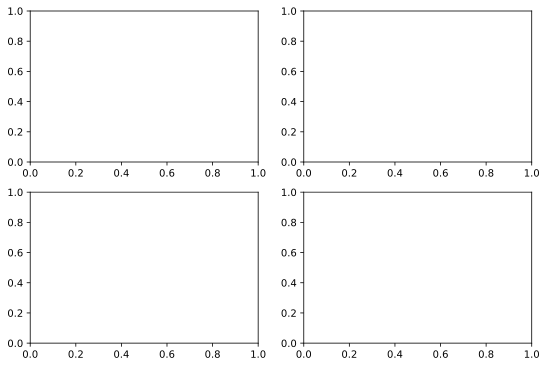

In [2]:
os.environ["CUDA_VISIBLE_DEVICE"]="0"
txt_foldername = os.path.join(os.getcwd(), "Result") #path to save intermediate results
txt_filename = "print_unet_message_version1.txt"

batch_size = 32
net = UNet()
num_epochs, lr, wd, devices = 1, 0.001, 1e-3, torch.device("cuda:0")
trainer = torch.optim.SGD(net.parameters(), lr=lr, weight_decay=wd)
animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1], nrows=2, ncols=2,
                   legend=['train loss', 'train acc', 'test acc'])
row_index = [0,0,1,1,2,2]
col_index = [0,1,0,1,0,1]

In [ ]:
print(torch.__version__)
print(torch.cuda.is_available())

In [ ]:
time_list = []
time_list.append(time.time()) #Record first time
for kNum in range(1):
      """Train net parameters"""
      trainData = dataSet(is_train=True, kNum=kNum, subType=["C0", "DE", "T2"])
      testData = dataSet(is_train=False, kNum=kNum, subType=["C0", "DE", "T2"])
      train_iter = torch.utils.data.DataLoader(trainData, batch_size, shuffle=True, drop_last=True) #由于剪裁结果一定相等，不需要指定collate_fn
      test_iter = torch.utils.data.DataLoader(testData, batch_size, shuffle=True, drop_last=True) #由于剪裁结果一定相等，不需要指定collate_fn

      Train(net, train_iter=train_iter, test_iter=test_iter, loss_type="weighted_cross_entropy+generalized_dice_loss",
            trainer=trainer, num_epochs=num_epochs, devices=devices,
            acc_type=["dice", "Average Symmetric Surface Diatance","Hausdorff distance",
                      "correct prediction of pixel", "specificity", "sensitivity",
                      "precision", "accuracy"],
            animator_type = "dice",
            kNum=kNum, Animator=animator, row=row_index[kNum], col=col_index[kNum],
            foldername=txt_foldername, filename=txt_filename).train() #Object and train model


      time_list.append(time.time())

for index in range(len(time_list)-1):
    print('kNum: %d; time cost: %.3f s'%(index, time_list[index+1]-time_list[index]))

************************Cross Validation: No.0************************


In [ ]:
%matplotlib notebook

for row in range(1):
    for col in range(1):
        animator.show_axes(row, col)

In [ ]:
torch.save(net.state_dict(), os.path.join(os.getcwd(), "Result", "saveNet_epo30_0.7GD+0.3WL_CV6_3LEGtypes.tar"))